In [1]:
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [2]:
random.seed(9001)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [3]:
df = pd.read_csv("M0405.csv")
print ("size of dataset  :", df.shape[0])
print ("size of station  :", df.s_stat.value_counts().shape[0])
print ("size of day      :", df.day.value_counts().shape[0])
print ("size of time step:", df.mins.value_counts().shape[0])
df.head()

size of dataset  : 7776
size of station  : 3
size of day      : 9
size of time step: 288


,year,mon,day,mins,s_stat,e_stat,clock,number,speed
0,2017,9,1,0,01F0750S,01F0880S,442,46,106
1,2017,9,1,5,01F0750S,01F0880S,447,31,105
2,2017,9,1,10,01F0750S,01F0880S,426,39,110
3,2017,9,1,15,01F0750S,01F0880S,441,41,106
4,2017,9,1,20,01F0750S,01F0880S,442,31,106


In [4]:
df1 = df[(df.s_stat == "01F0750S")].iloc[:,6:].reset_index(drop=True)
df2 = df[(df.s_stat == "01F0880S")].iloc[:,6:].reset_index(drop=True)
df3 = df[(df.s_stat == "01F0928S")].iloc[:,6:].reset_index(drop=True)

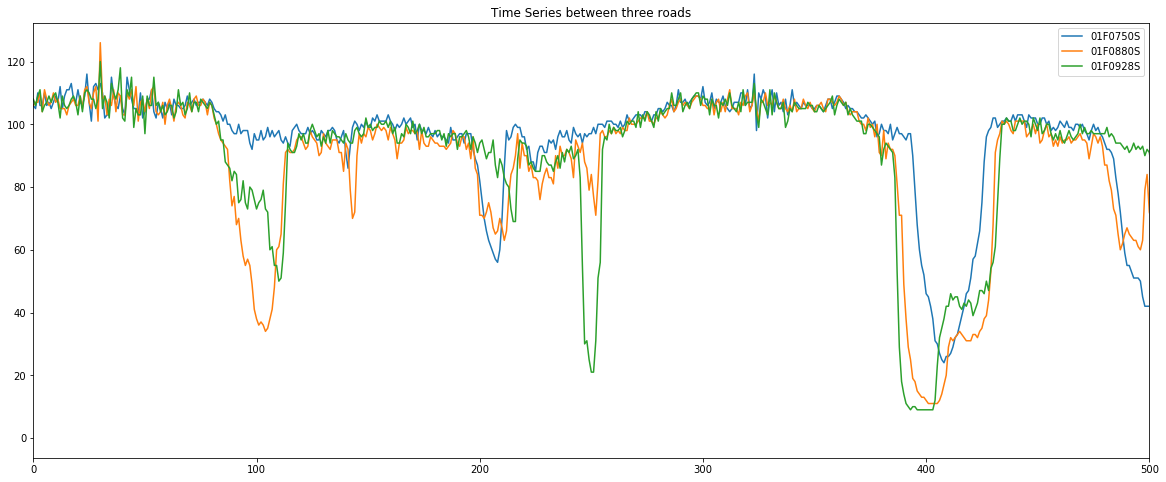

In [5]:
plt.figure(figsize=(20, 8))

plt.plot(df1.speed)
plt.plot(df2.speed)
plt.plot(df3.speed)

plt.legend(['01F0750S', '01F0880S', '01F0928S'], loc='upper right')
plt.title("Time Series between three roads")
plt.xlim(0, 500) #2592
plt.show()

> 前一個路段塞車會推演到下一個路段，後一個路段塞車也可能會影響到前一個路段。

In [6]:
# 因為發現前後站與當站會影響當站，擷取前個時間點的資訊
df_ = pd.concat([df1, df2, df3, df2.speed], axis=1)
df_.columns = ["last_c","last_n","last_s","_c","_n","_s","next_c","next_n","next_s","speed"]
df_.head()

,last_c,last_n,last_s,_c,_n,_s,next_c,next_n,next_s,speed
0,442,46,106,163,44,106,73,31,108,106
1,447,31,105,162,31,107,74,27,106,107
2,426,39,110,161,35,107,73,20,109,107
3,441,41,106,156,43,110,71,35,111,110
4,442,31,106,165,41,104,76,28,104,104


### Random Forest Regression

In [7]:
# shift row for last step
X = df_.iloc[:-1,:9]
y = df_.iloc[1:,9].reset_index(drop=True)
print (X.head())
print (y.head())

sc = StandardScaler(copy=True, with_mean=True, with_std=True)
X = sc.fit_transform(X)

   last_c  last_n  last_s   _c  _n   _s  next_c  next_n  next_s
0     442      46     106  163  44  106      73      31     108
1     447      31     105  162  31  107      74      27     106
2     426      39     110  161  35  107      73      20     109
3     441      41     106  156  43  110      71      35     111
4     442      31     106  165  41  104      76      28     104
0    107
1    107
2    110
3    104
4    111
Name: speed, dtype: int64


In [8]:
# training and testing on (0.8, 0.2)
train_test = int(X.shape[0]*0.8)

X_train = X[ :train_test, : ]
y_train = y.iloc[ :train_test, ]
X_test = X[ train_test:, : ]
y_test = y.iloc[ train_test:, ]
print ("size of train rows     :", X_train.shape[0])
print ("size of train features :", X_train.shape[1])


size of train rows     : 2072
size of train features : 9


In [9]:
col = df_.columns[:9]
def training(model):
    t0 = time.time()
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    t1 = time.time()
    print("training time %f sec" % (t1 - t0))
    print ("mean squared error :", (-1*sum(score)/10))
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(col)), model.feature_importances_)
    plt.xticks(np.arange(len(col)), col)
    plt.ylim(0, 0.6)
    plt.ylabel("feature_importances")
    plt.title("Feature Importances of Random Forest Regression")
    plt.show()
    
def testing(y_test, pred, xlim):
    print ("mean squared error :", mean_squared_error(y_test, pred))
    
    plt.figure(figsize=(8, 8))
    plt.scatter(np.array(y_test), np.array(pred), s=30, c='g', alpha=0.5)
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(pred), np.max(pred)], "k-", color="r")
    plt.xlabel('True')
    plt.ylabel('Prediction')
    plt.title('Scatter plot between true and pred')
    plt.show()
    
    plt.figure(figsize=(20, 8))
    plt.plot(np.array(y_test))
    plt.plot(pred)
    plt.legend(['True', 'Prediction'], loc='upper right')
    plt.title("Time Series between three roads")
    plt.xlim(0, xlim)
    plt.show()


In [10]:
para = [{'n_estimators': [100, 300, 500, 1000], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9]}]

rfr = RandomForestRegressor()
clf = GridSearchCV(rfr, para, cv=10, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
clf = clf.best_estimator_
print (clf)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


training time 28.929414 sec
mean squared error : 14.6319994509


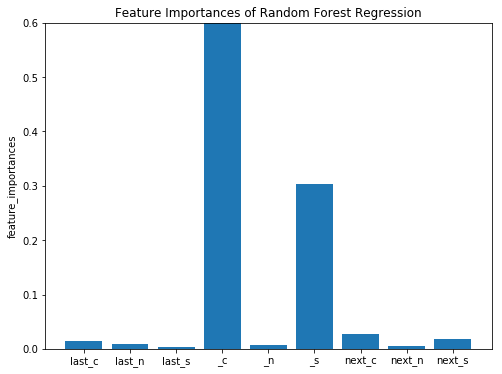

In [11]:
training(clf)


mean squared error : 14.7879222042


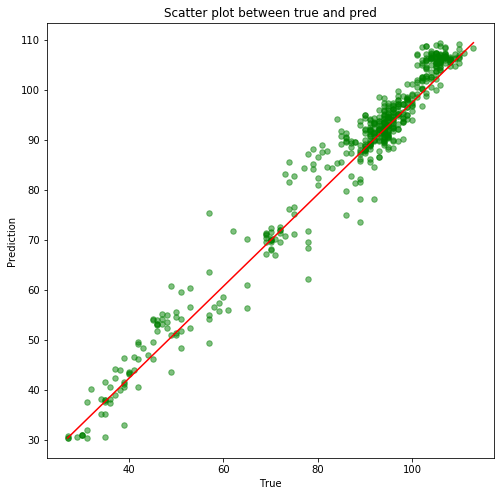

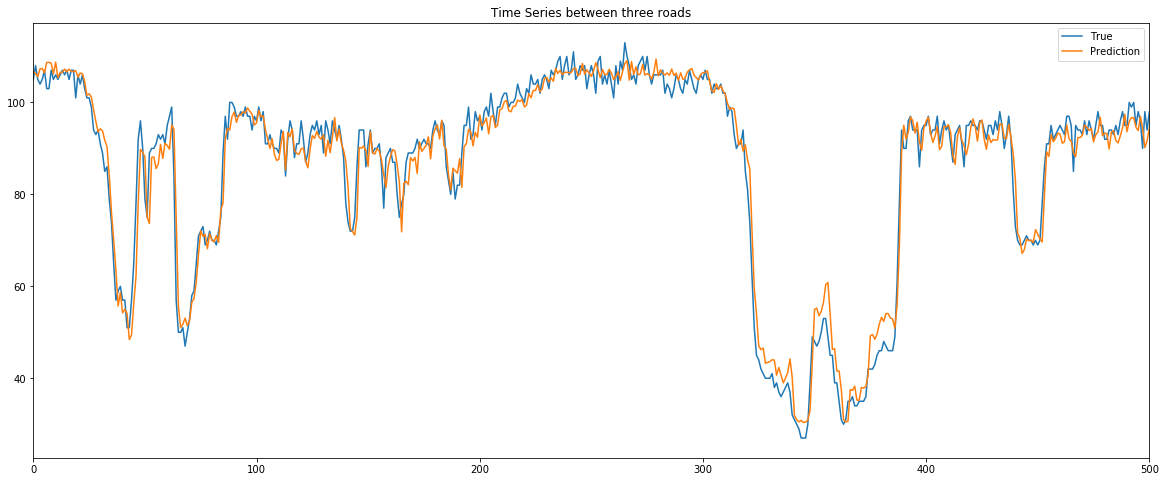

In [12]:
pred = clf.predict(X_test)
testing(y_test, pred, 500)


training time 3.918340 sec
mean squared error : 16.3644336975


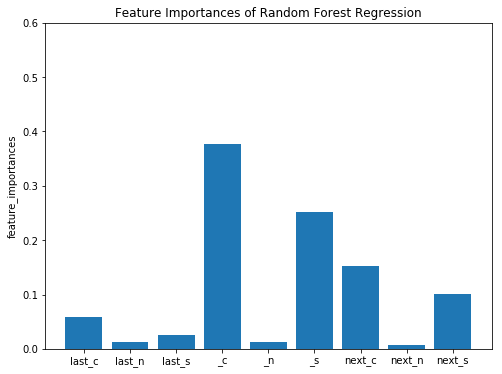

In [13]:
# random forest regression
rfr = RandomForestRegressor(n_estimators=100, max_features=3)
training(rfr)

mean squared error : 13.9465121387


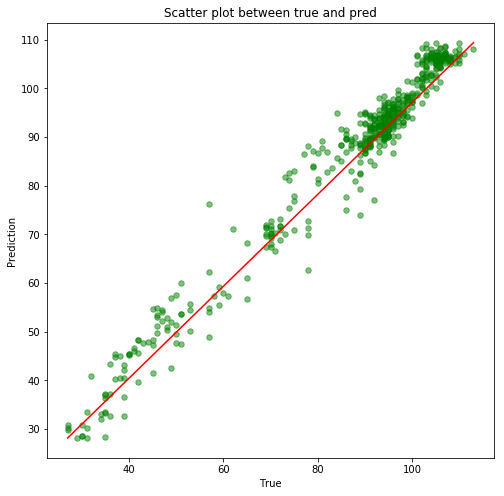

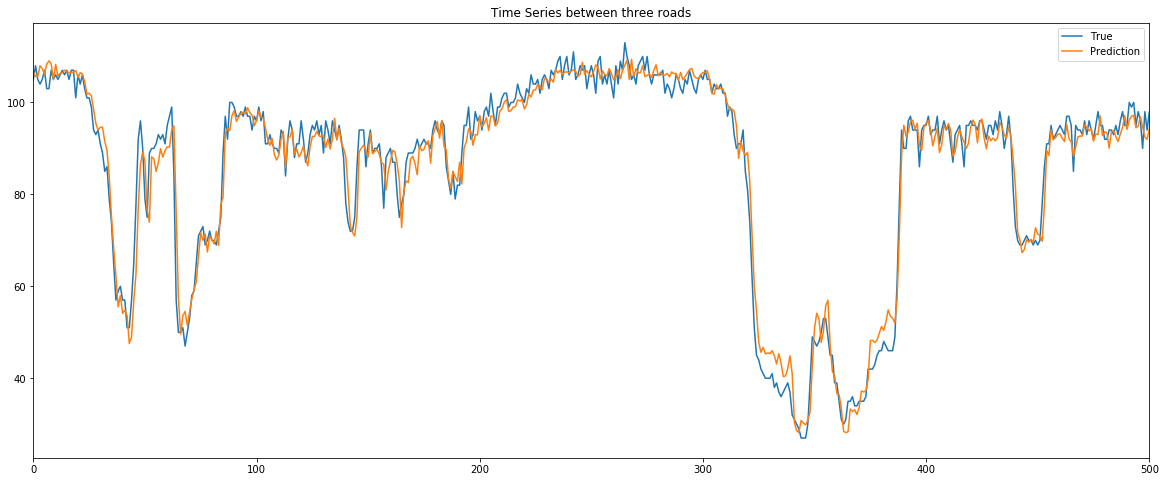

In [14]:
pred = rfr.predict(X_test)
testing(y_test, pred, 500)

1. 問題：塞車理論
2. 找出塞車點
3. 給定即將進站的駕駛建議速率
4. 方法：
    a. 利用時間序列圖，發現當站當時的流量與前後站前一時間點都有關連。  
    b. 利用前一時間點的9個欄位，去預測當站當時的行車速率。  
    c. 並利用kmeans分群找出可能塞車的地點。  
    d. 並建議即將進站的駕駛人建議速率?????  
    e. 以解決塞車理論的問題。
5. 結果：本身預測結果算精準，kmeans分群也能準確找出塞車點。
6. 未來展望：  
    a. 希望加入更多資訊(天氣或道路狀況)增加預測準確性  
    b. 利用更複雜的機率模型(poisson)去給出給好的建議速率  
    c. 需要多人共同使用才能順利舒緩塞車問題  

### RNN

In [15]:
X = df_.iloc[:-1,:9]
y = df_.iloc[1:,9].reset_index(drop=True)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


In [16]:
# training and testing on (0.8, 0.2)
train_test = int(X.shape[0]*0.8)

X_train = X[ :train_test, : ]
y_train = y.iloc[ :train_test, ]
X_test = X[ train_test:, : ]
y_test = y.iloc[ train_test:, ]
print ("size of train rows     :", X_train.shape[0])
print ("size of test rows      :", X_test.shape[0])
print ("size of train features :", X_train.shape[1])

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print ("shape of rnn input :", X_train.shape)

size of train rows     : 2072
size of test rows      : 519
size of train features : 9
shape of rnn input : (2072, 1, 9)


In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, return_sequences = False, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [38]:
epochs = 100
batch_size = 1

t0 = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
t1 = time.time()
print("training time %f sec" % (t1 - t0))


training time 1341.138898 sec


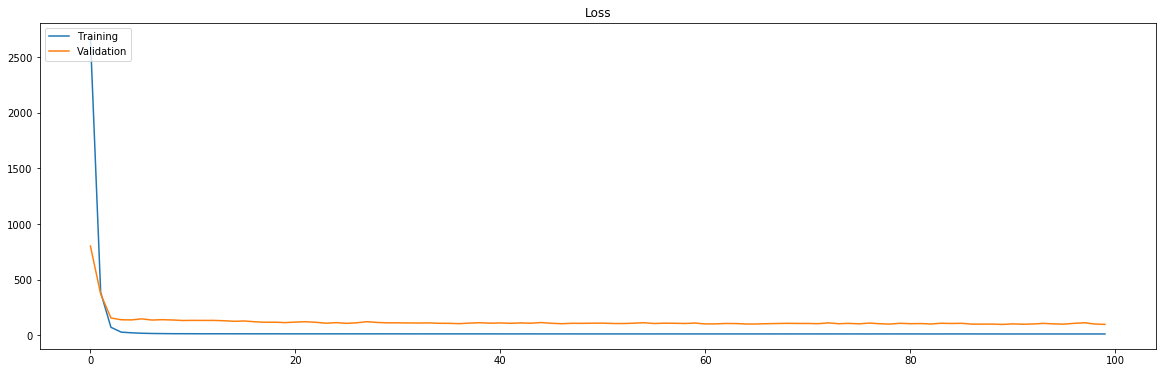

In [39]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.figure(figsize=(20, 6))
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.show()


mean squared error : 18.5797551464


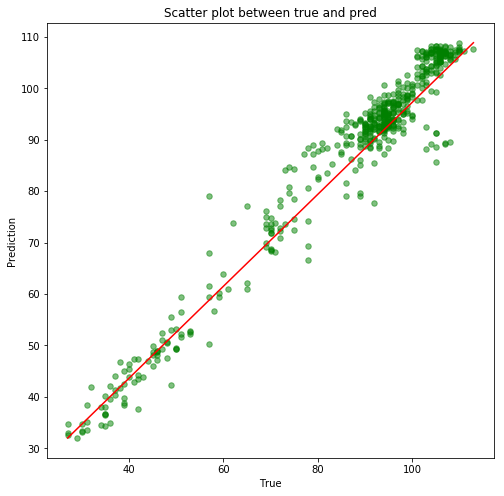

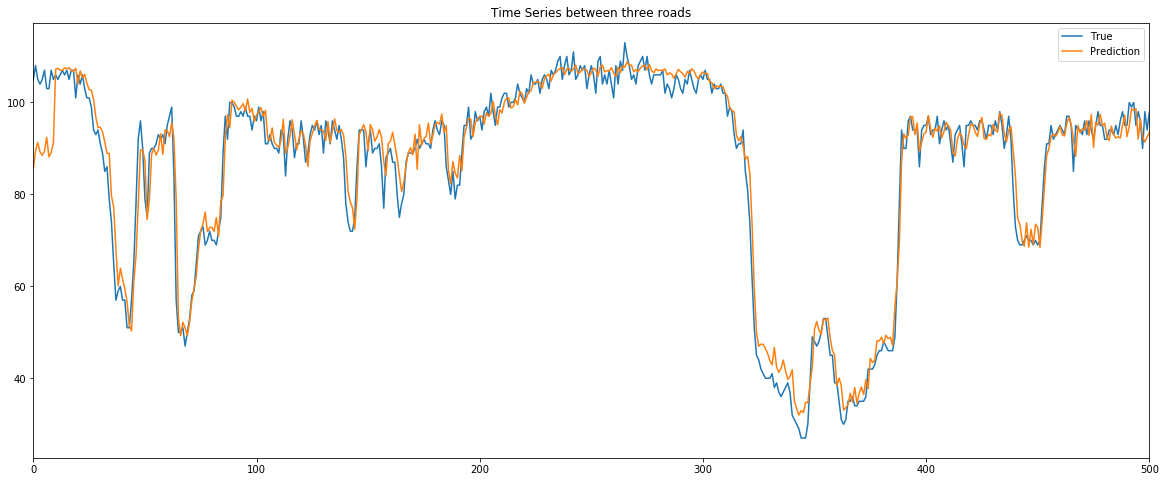

In [40]:
pred = model.predict(X_test, verbose=0)
testing(y_test, pred, 500)

1. lstm 4  -> 14.4474887334
2. lstm 64 -> 13.4587027613
3. lstm 128 -> 14.6004538192
4. lstm 128, 64 -> 21.2214517716
5. lstm 64, batch_size:16 -> 20.3097623214
6. lstm 64, batch_size:2 -> 20.xxx
7. lstm 32 -> 16.8600828386